In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [5]:
Base = automap_base()

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)


# reflect the tables
Base.classes.keys()


['measurement', 'station']

In [7]:
# We can view all of the classes that automap found
session = Session(bind=engine)

Station = Base.classes.station
Measurement = Base.classes.measurement

# here are the fields for station
first_row = session.query(Station).first()
first_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x159b0d606a0>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [8]:
# here are the fields for measurement
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x159b0d60438>,
 'prcp': 0.08,
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01',
 'station': 'USC00519397'}

In [9]:
# Save references to each table  # this is a repeat
Station = Base.classes.station
Measurement = Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB

conn = engine.connect()

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# I used SQL query in this portion and in the flask app, I used session queries.

# Calculate the date 1 year ago from the last data point in the database
data = pd.read_sql("SELECT max(date) as final_date FROM measurement ", conn)

# save the max date and place that into a variable that we can manipulate
last_date = data.iloc[0].tolist()
datetimeObj = datetime.strptime(last_date[0], '%Y-%m-%d')

# grab just the year
year = datetimeObj.strftime("%Y")

# subtract 1 from it.  Could of also subtracted 365 days from the date
year = int(year) -1

# rebuild the string based on the new date
new_year = str(year) + '-' + datetimeObj.strftime("%m") + '-' + datetimeObj.strftime("%d")

#show what was calculated.
print(new_year)

# Perform a query to retrieve the data and precipitation scores
query = f"SELECT date, prcp FROM measurement where date > '{new_year}'"
print(query)

# Save the query results as a Pandas DataFrame and set the index to the date column

data = pd.read_sql(query, conn)

# set the date as the index
data.set_index('date',inplace=True)

# Sort the dataframe by date
data.sort_index(inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
data.dropna(inplace=True)


2016-08-23
SELECT date, prcp FROM measurement where date > '2016-08-23'


In [12]:
# display a portion of the data
data.head()


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45


C:\Users\Bill\anaconda3\envs\PythonData\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


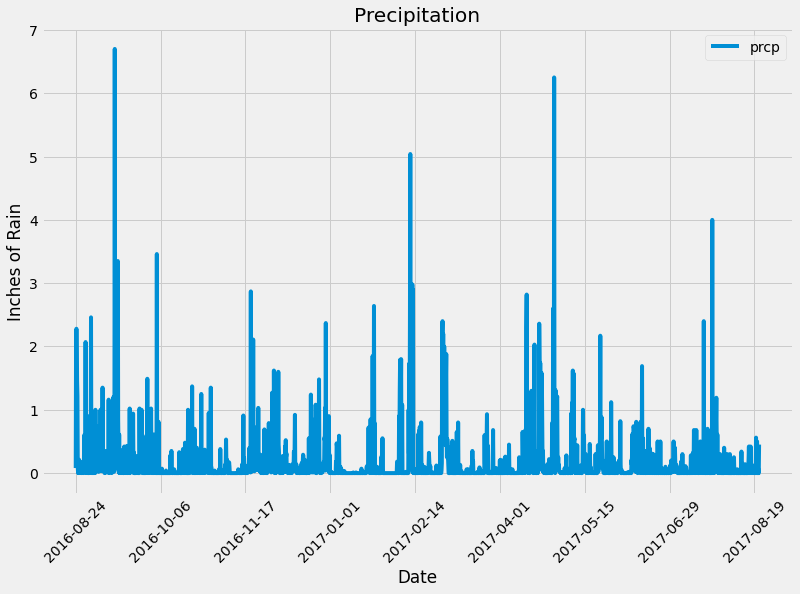

In [14]:
# plot the data
data.plot(kind='line',figsize=(12,8),title='Precipitation',stacked=True,fontsize=14)
plt.xlabel('Date')
plt.ylabel('Inches of Rain')
plt.xticks(rotation=45)
plt.show()

In [15]:
# This is a second attempt to plot using matplotlib.  I wasn't successful to reduce the number of ticks.
dates = data.index.get_level_values('date').unique()
x_axis = np.arange(len(dates))
print(dates)

Index(['2016-08-24', '2016-08-25', '2016-08-26', '2016-08-27', '2016-08-28',
       '2016-08-29', '2016-08-30', '2016-08-31', '2016-09-01', '2016-09-02',
       ...
       '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17', '2017-08-18',
       '2017-08-19', '2017-08-20', '2017-08-21', '2017-08-22', '2017-08-23'],
      dtype='object', name='date', length=365)


<function matplotlib.pyplot.show(close=None, block=None)>

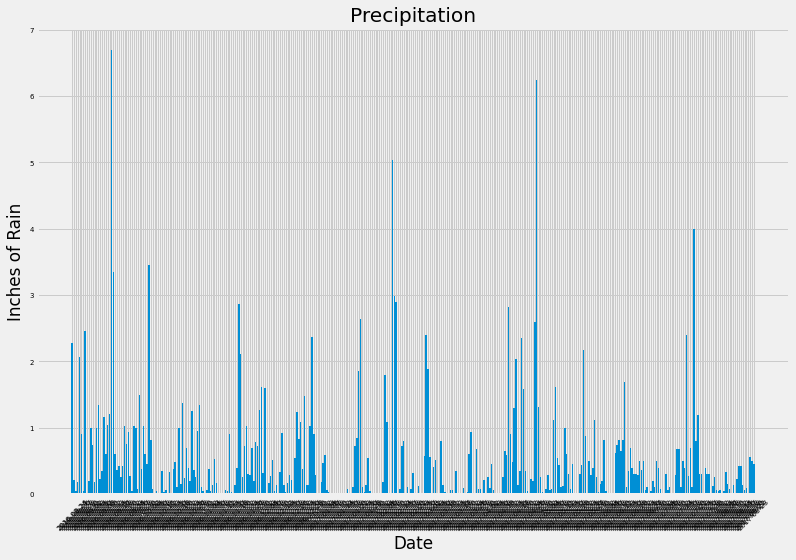

In [16]:
# Tell matplotlib where we would like to place each of our x axis headers
tick_locations = [value for value in x_axis]
#tick_locations


fig= plt.figure(figsize=(12,8))
plt.xticks(tick_locations, dates, rotation=45)
plt.bar(data.index.get_level_values('date'),data['prcp'])
plt.tick_params(labelsize=7)
plt.xlabel('Date')
plt.ylabel('Inches of Rain')
plt.title('Precipitation')
plt.show

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
station_count = pd.read_sql("SELECT count(station) as 'Station Count' from station", conn)
station_count.set_index("Station Count",inplace=True)
station_count.head()

""
Station Count
9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active = pd.read_sql("SELECT station, count(station) as Station_count from measurement group by station order by Station_count desc", conn)
active.head(10)


,station,Station_count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temps = pd.read_sql("SELECT station, min(tobs) as 'Lowest Temperature', max(tobs) as 'Maximum Temperature', AVG(tobs) as 'Average Temperature', count(tobs) as Number_of_readings from measurement where station = 'USC00519281' group by station order by Number_of_readings desc", conn)
temps.head()


,station,Lowest Temperature,Maximum Temperature,Average Temperature,Number_of_readings
0,USC00519281,54.0,85.0,71.663781,2772


In [21]:
#temps.query('index == 0',inplace=True)
# get the top row of the dataframe
row = next(temps.iterrows())[1]

# pull the station from the top row
top_station=row['station']

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#new_year is still valid from above.  top_station was calculated in the cell above.  Print out the query to confirm what is
# being done.

query = f"SELECT date, tobs FROM measurement where (station = '{top_station}' ) and (date > '{new_year}')"
print(query)

# Pull the data from the sqlite database.
tobs_df = pd.read_sql(query, conn)


SELECT date, tobs FROM measurement where (station = 'USC00519281' ) and (date > '2016-08-23')


In [23]:
# View of the date pulled from the database.
tobs_df.head()
tobs_df.count()


date    351
tobs    351
dtype: int64

(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 52., 29.,  8.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <BarContainer object of 12 artists>)

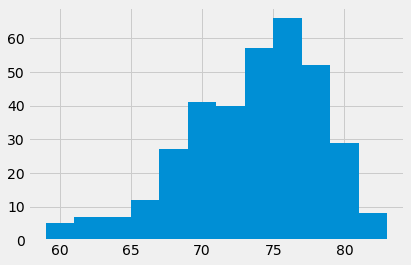

In [24]:
# plot the data based on the request.
n_bins = 12

x = tobs_df['tobs']
y = tobs_df['tobs'].count()

plt.hist(x,bins=n_bins)



## Bonus Challenge Assignment

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# I picked 3 vacation trips and plotted those
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip1 = calc_temps('2016-11-01','2016-11-08')
trip2 = calc_temps('2017-01-01','2017-01-08')
trip3 = calc_temps('2017-06-29','2017-07-06')

<function matplotlib.pyplot.show(close=None, block=None)>

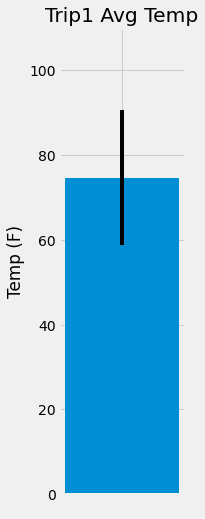

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_axis = [' ']
fig= plt.figure(figsize=(2,8))
plt.ylabel('Temp (F)')
plt.title('Trip1 Avg Temp')
plt.ylim(0,110)
plt.bar(x_axis,trip1[0][1],yerr=(trip1[0][2]-trip1[0][0]),width=.5)
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

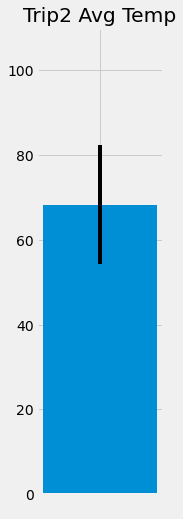

In [28]:
# second vacation trip
fig= plt.figure(figsize=(2,8))
plt.title('Trip2 Avg Temp')
plt.ylim(0,110)
plt.bar(x_axis,trip2[0][1],yerr=(trip2[0][2]-trip2[0][0]),width=.5)
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

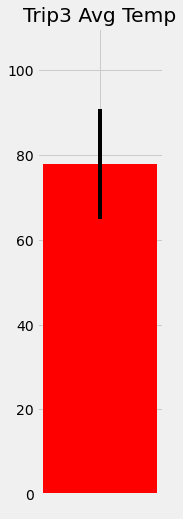

In [29]:
# Third vacation trip
fig= plt.figure(figsize=(2,8))
plt.title('Trip3 Avg Temp')
plt.ylim(0,110)
plt.bar(x_axis,trip3[0][1],yerr=(trip3[0][2]-trip3[0][0]),width=.5,color='red')
plt.show

In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

result_prcp = session.query(Measurement.station,Measurement.date,Measurement.prcp)\
    .filter(Measurement.date > '2016-11-01')\
    .filter(Measurement.date < '2016-11-08')

# Convert the list into a dictionary
trip_results = {}
for day_results in result_prcp:
    # verify the data is pulled
    if day_results.prcp is not None:
        
        # if there is data save that into the dictionary. Check to see if the date was seen already
        if (day_results.station) in trip_results:
            
            # if the data is an existing recorded date, add it to the previous value
            trip_results[day_results.station] = trip_results[day_results.station] + float(day_results.prcp)
        else:
            # first time collecting for this date.
            trip_results[day_results.station] =  float(day_results.prcp)

# Prepare for the plot
results_df = pd.DataFrame(trip_results,['Precipitation'])

# transpose from columns to rows
results1_df = pd.melt(results_df)

#rename the columns
results1_df.rename(columns = {'variable': 'Stations' ,'value' : 'Precipitation'}, inplace=True)

# sort the data into descending order
results1_df.sort_values('Precipitation',ascending=False,inplace=True)

query = f"SELECT * FROM station"
print(query)

# Pull the data from the station table.
station_df = pd.read_sql(query, conn)


SELECT * FROM station


In [31]:
# Display the results
station_df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [32]:
# merge the data from the measurement tables with the station particulars
final_data_df = pd.merge(results1_df,station_df,left_on='Stations',right_on='station')

# drop the columns not needed and display
final_data_df.drop(columns=['id','station'],inplace=True)
final_data_df

,Stations,Precipitation,name,latitude,longitude,elevation
0,USC00516128,0.60,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00514830,0.13,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,USC00513117,0.04,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519281,0.04,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
4,USC00519523,0.02,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00519397,0.00,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("11-01")

[(65.0, 74.86274509803921, 83.0)]

In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Strip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

# I took the first trip as a continued example
start_date = '2016-11-01'
end_date = '2016-11-08'

# Pull the days and create a list
datetimeObj = datetime.strptime(start_date, '%Y-%m-%d')
sd = int(datetimeObj.strftime("%d"))
datetimeObj = datetime.strptime(end_date, '%Y-%m-%d')
ed = int(datetimeObj.strftime("%d"))
days = np.arange(sd,ed+1,1,'int')

#Loop through the days and store the days and the results into a normals and date list
normals_list=[]
date_list = []

#loop through the days
for day in days:
    # make a string date and store the date into the date_list
    date_str = datetimeObj.strftime("%m") + '-0' + str(day)
    date_list.append(date_str)
    
    #call the routine and find the results
    normals_list.append(daily_normals(date_str)[0])
    
# print out the results
print(normals_list)
print(date_list)



[(65.0, 74.86274509803921, 83.0), (64.0, 74.0625, 81.0), (66.0, 74.95918367346938, 82.0), (65.0, 74.0754716981132, 82.0), (64.0, 73.5576923076923, 78.0), (66.0, 74.31111111111112, 81.0), (63.0, 73.76, 80.0), (67.0, 73.75, 81.0)]
['11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08']


In [35]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(normals_list,columns = ['Min','Avg','Max'],index=date_list)
normal_df

,Min,Avg,Max
11-01,65.0,74.862745,83.0
11-02,64.0,74.062500,81.0
11-03,66.0,74.959184,82.0
11-04,65.0,74.075472,82.0
11-05,64.0,73.557692,78.0
11-06,66.0,74.311111,81.0
11-07,63.0,73.760000,80.0
11-08,67.0,73.750000,81.0


(0.0, 87.15)

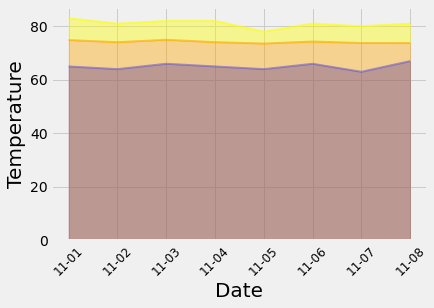

In [37]:
# Plot the daily normals as an area plot with `stacked=False`

plt.fill_between(normal_df.index.get_level_values(0).values,0, normal_df['Min'],\
                 color="Blue", alpha=0.4)
plt.plot(normal_df.index.get_level_values(0).values, normal_df['Min'], color="Slateblue",\
         alpha=0.6, linewidth=2)
plt.fill_between(normal_df.index.get_level_values(0).values, normal_df['Avg'], normal_df['Max'],\
                 color="Yellow", alpha=0.4)
plt.plot(normal_df.index.get_level_values(0).values, normal_df['Max'], color="Yellow",\
         alpha=0.6, linewidth=2)
plt.fill_between(normal_df.index.get_level_values(0).values, normal_df['Avg'],\
                 color="Orange", alpha=0.4)
plt.plot(normal_df.index.get_level_values(0).values, normal_df['Avg'], color="Orange",\
         alpha=0.6, linewidth=2)


plt.xticks(np.arange(8), normal_df.index.get_level_values(0).values,rotation=45,size=12)
plt.xlabel('Date', size=20)
plt.ylabel('Temperature', size=20)
plt.ylim(bottom=0)